# Naive Experiment

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import datetime

import open_cp
import open_cp.kde as kde

## Datos:

### Esquinas y Centro

In [16]:
times = [datetime.datetime(2018,1,1) + datetime.timedelta(days=np.random.randint(0,360)) for _ in range(1000)]
#times.sort()

#centro

mean = (250,250)
cov = [[2500, 0], [0, 2500]]
x = np.random.multivariate_normal(mean, cov, (3, 3))
x.shape

a = np.random.multivariate_normal(mean, cov, 500)
xc1 = a.T[0]
yc1 = a.T[1]

# esquina

mean = (400,400)
cov = [[100, 0], [0, 100]]
x = np.random.multivariate_normal(mean, cov, (3, 3))
x.shape

a = np.random.multivariate_normal(mean, cov, 250)
xc2 = a.T[0]
yc2 = a.T[1]




xc3 = np.concatenate((xc1,xc2), axis=0)
yc3 = np.concatenate((yc1,yc2), axis=0)

# otra esquina

mean = (100,100)
cov = [[100, 0], [0, 100]]
x = np.random.multivariate_normal(mean, cov, (3, 3))
x.shape

a = np.random.multivariate_normal(mean, cov, 250)
xc3 = a.T[0]
yc3 = a.T[1]

xc = np.concatenate((xc3,xc2,xc1), axis=0)
yc = np.concatenate((yc3,yc2,yc1), axis=0)

combined = np.vstack((xc, yc)).T
np.random.shuffle(combined)

xc =  combined.T[0]
yc =  combined.T[1]

#np.random.shuffle(xc)
#np.random.shuffle(yc)

points = open_cp.TimedPoints.from_coords(times, xc, yc)

### Características de los datos

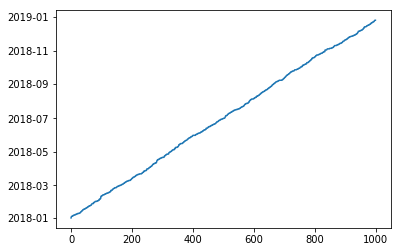

In [17]:
plt.plot(points.timestamps)
plt.show()

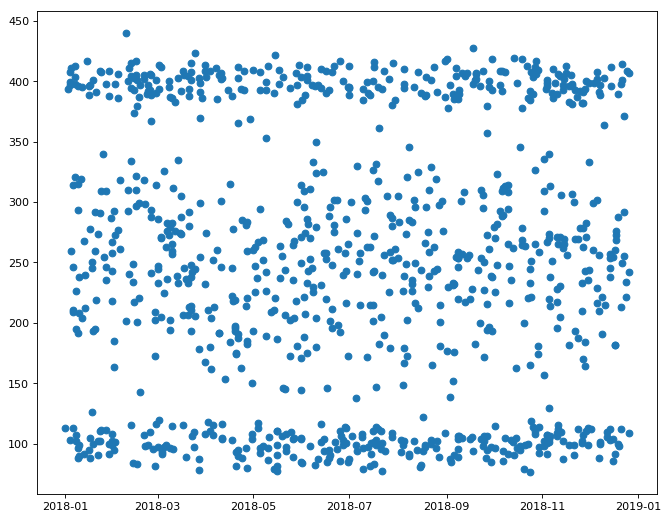

In [18]:
import matplotlib
from matplotlib.pyplot import figure

dates = matplotlib.dates.date2num(points.timestamps)
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot_date(dates, xc)


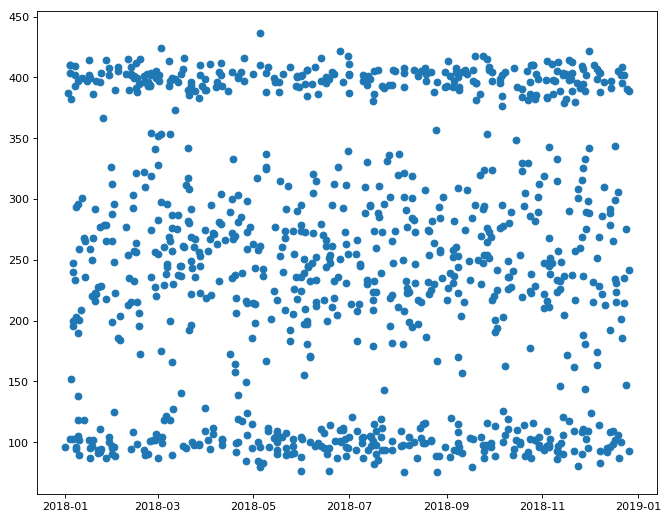

In [19]:
dates = matplotlib.dates.date2num(points.timestamps)
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot_date(dates, yc)

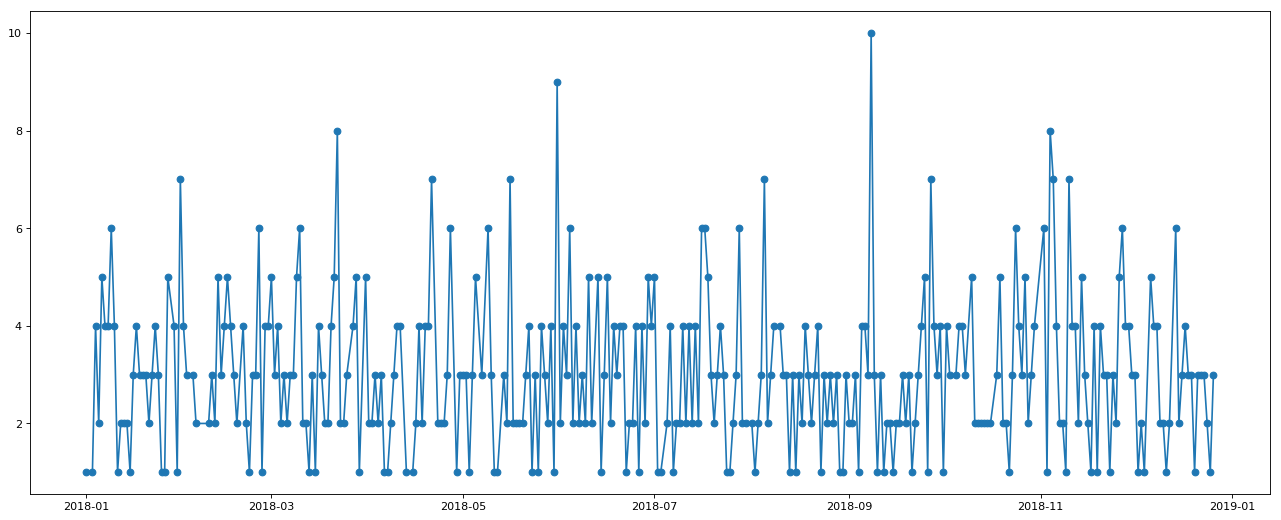

In [20]:
unique, counts = np.unique(points.timestamps, return_counts=True)
a = np.array((unique, counts))
figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(a[0], a[1], '-o')

## Región de Análisis

In [21]:
region = open_cp.RectangularRegion(0,500, 0,500)

## Parámetros de tiempo


In [37]:
predict_time = datetime.datetime(2018,11,10)
score_end_time = predict_time + datetime.timedelta(days=7)
score_end_time

datetime.datetime(2018, 11, 17, 0, 0)

In [38]:
#training: 2018-01-01T00:00:00.000 2018-10-29T00:00:00.000
test = points[points.timestamps > datetime.datetime(2018,10,29)]
print('test: ', min(test)[0], max(test)[0])

test:  2018-10-30T00:00:00.000 2018-12-26T00:00:00.000


## SEPP

In [39]:
#importamos el archivo seep.pickle
#training: 2018-01-01T00:00:00.000 2018-10-29T00:00:00.000
import pickle
pickle_in = open("seep.pickle","rb")
predictor_seep = pickle.load(pickle_in)
predictor_seep

In [40]:
predictor_seep.data = test
predictor_seep = predictor_seep.predict(score_end_time) 

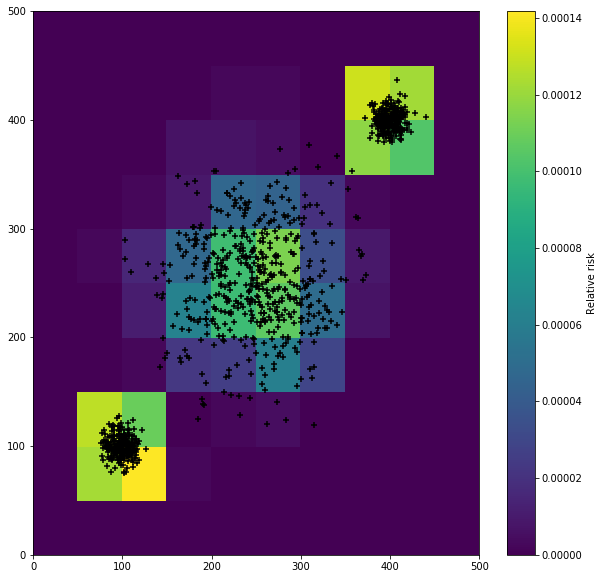

In [41]:
fig, ax = plt.subplots(figsize=(10,10))

m = ax.pcolor(*predictor_seep.mesh_data(), predictor_seep.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")

None

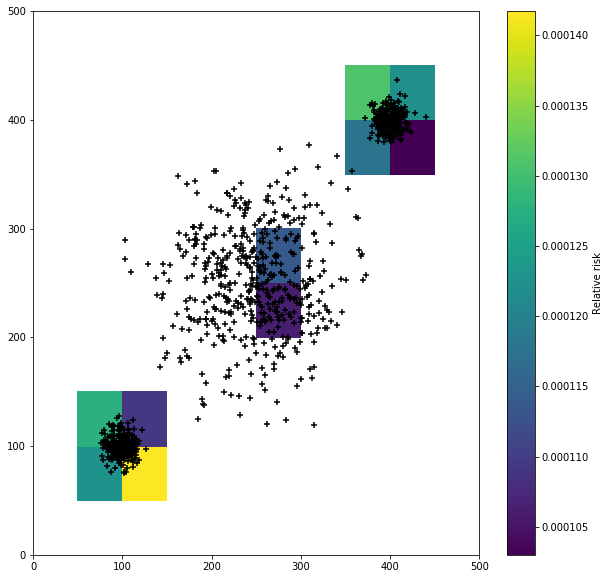

In [42]:
from open_cp import evaluation

predictor = open_cp.evaluation.top_slice_prediction(predictor_seep, 10/100)
#ax, cb = plot_grid_prediction(geo, grid_pred)

fig, ax = plt.subplots(figsize=(10,10))

m = ax.pcolor(*predictor.mesh_data(), predictor.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")
None

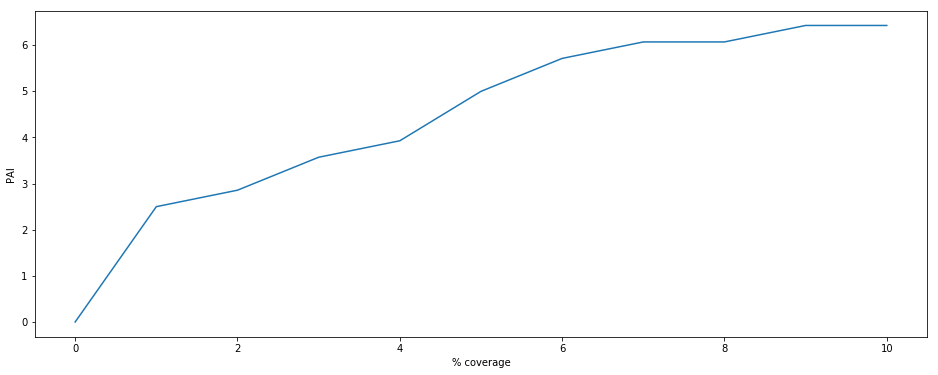

In [43]:
#porcentaje de área (10%)
coverages = list(range(0, 11))

mask = (points.timestamps >= predict_time) & (points.timestamps <= score_end_time)
eval_pts = points[mask]
hitrates = open_cp.evaluation.hit_rates(predictor_seep, eval_pts, coverages)

pai = np.zeros(len(hitrates))
for i in range(len(hitrates)):
    pai[i] = hitrates[i]/(10/100)


fig, ax = plt.subplots(figsize=(16,6))

ax.plot(coverages, [pai[x] for x in coverages])
ax.set(xlabel="% coverage", ylabel="PAI ")
None